### Установки

In [1]:
!pip install navec
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2023-04-23 07:20:22--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.8MB/s    in 3.0s    

2023-04-23 07:20:26 (16.8 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’ saved [53012480/53012480]



### Импорты

In [3]:
from research.utils import (split_df_texts_by_sentences, 
                            lemmatize_splitted_df_sentences,
                            get_sentence_vectors_from_lemmatized_text)

from sklearn.model_selection import train_test_split
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from navec import Navec
import pandas as pd
import numpy as np
import joblib
import nltk

In [4]:
path = './navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)
nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Применение модели к трейну, замер accuracy

In [5]:
df_train = pd.read_json('./data/train.json', encoding='utf-8')  # загружаем данные из train.json
df_train.head()

,id,text,label,extracted_part
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить обесп...
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...


Загрузим модели для классификации предложений в зависимости от label (подробно в reserch/base_model)

In [6]:
# загрузка обученных моделей
contract_enforcement_model = joblib.load('./data/models/contract_enforcement_xgb_model.joblib')
garantee_enforcement_model = joblib.load('./data/models/garantee_enforcement_xgb_model.joblib')

In [7]:
df_splitted = split_df_texts_by_sentences(df_train.copy())  # делим тексты на предложения
df_lemmatized = lemmatize_splitted_df_sentences(df_splitted.copy(), stopwords_ru, morph)  # приводим слова в предложениях к нормальному виду

Далее для применения моделей необходимо превратить "лемматизированные" предложения в векторы предложений. С этим нам поможет библиотека Navec. Navec - это библиотека предварительно подготовленных ембендингов слов для русского языка. 

Подробнее: https://github.com/natasha/navec?ysclid=lgi8rvqlyo416346758

Такой векторизатор я реализовал в виде функции get_sentence_vectors_from_lemmatized_text в модуле utils. (см research/utils.py) 

Далее нам необходимо реализовать функции для предсказания, т.к. модели две 

In [8]:
def get_predicted_sentence_index_for_contract_enforcement(df_lemmatized_object, min_rate=0.4):
  shape = 83  # определяем максимальную длину вектора предожения
  vectorized_text = get_sentence_vectors_from_lemmatized_text(df_lemmatized_object['text'], shape, navec)  # функция создаёт векторы предложений из их списка
  # в итоге на выходе получаем векторизованный текст


  max_probability=0 
  index = -1
  try:
    # проходим по каждому предложению и считаем "вероятность" принадлежности его к целевому классу
    for i in range(len(vectorized_text)):
      vector = vectorized_text[i]
      vector = np.array(vector)
      vector = vector.reshape((1, shape))  
      pred = contract_enforcement_model.predict_proba(vector)[0][1]

      # сохраняем индекс предложения с наибольшей "вероятностью"
      if pred > max_probability and pred > min_rate:
        max_probability = pred
        index = i
  except Exception as e:
    print(vector.shape, vector, df_lemmatized_object['label'], e)  # добавляем дебаг-логирование
  
  return index, max_probability

И такую же функцию для лейбла "обеспечение гарантийных обязательств"

In [9]:
def get_predicted_sentence_index_for_garantee_enforcement(df_lemmatized_object, min_rate=0.8):
  shape = 83  # определяем максимальную длину вектора предожения

  # создание векторов предложений
  vector_text = get_sentence_vectors_from_lemmatized_text(df_lemmatized_object['text'], shape, navec)

  max_probability=0
  index = -1

  try: 
    for i in range(len(vector_text)):
      sentence_vector = vector_text[i]
      sentence_vector = np.array(sentence_vector)
      sentence_vector = sentence_vector.reshape((1, shape))
      # применение модели к вектору предложения
      pred = garantee_enforcement_model.predict_proba(sentence_vector)[0][1]

      # сохранение наилучшего результата
      if pred > max_probability and pred > min_rate:
        max_probability = pred
        index = i
  except Exception as e:
    print(sentence_vector.shape, sentence_vector, df_lemmatized_object['label'], e)

  return index, max_probability

Далее напишем функцию для построчной обработки датафрейма и передачи текстов в функции в зависимости от лейблов

In [18]:
def predict_sentence(df_lemmatized, stopwords_ru, morph, min_garantee_enforcement_rate=0.8, min_contract_enforcement_rate=0.4):
  """
  Input: pd.DataFrame с нормализаванными предложениями. 
  Пример поля ['text']:
  [['способ', 'определение', 'поставщик', 'подрядчик', 'исполнитель'], ['электронный', 'аукцион'], ....]

  Output: pred:list список предсказаний. 
  """

  pred = []
  # пробегаемся по текстам и отправляем их в соответствующую label модель
  for i in range(len(df_lemmatized)):
    if df_lemmatized.loc[i, 'label'] == 'обеспечение исполнения контракта':
      
      index, _ = get_predicted_sentence_index_for_contract_enforcement(df_lemmatized.loc[i, :], min_contract_enforcement_rate)
      pred.append(df_splitted.loc[i, 'text'][index] if index != -1 else None)  # добавляем искомое предложение в pred

    elif df_lemmatized.loc[i, 'label'] == 'обеспечение гарантийных обязательств': 
      index, _ = get_predicted_sentence_index_for_garantee_enforcement(df_lemmatized.loc[i, :], min_garantee_enforcement_rate)
      pred.append(df_splitted.loc[i, 'text'][index] if index != -1 else None)  # добавляем искомое предложение в pred

    else:
      print('Неверное значение label')
  return pred

Протестируем полученные модели

In [19]:
predictions = predict_sentence(df_lemmatized, stopwords_ru, morph, min_garantee_enforcement_rate=0.8)

In [20]:
def accuracy_count(df_train, predictions):
  # проверяем объекты на входе
  assert len(df_train) == len(predictions), f'Объекты должны иметь одинаковую длину: df_train: {len(df_train)}, predictions: {len(predictions)}'
  counter = 0
  i = 0
  # считаем accuracy
  for extracted_part, pred in zip(df_train.loc[:, 'extracted_part'].values, predictions):
    if pred == extracted_part['text'][0] or (pred is None and  extracted_part['text'][0] == ''):
      counter += 1

    else: 
      query = f"""
      index = {i}\n
      prediction: {pred}\n
      target: {extracted_part['text'][0]}\n\n
      """
      with open('errors.txt', 'a') as f:
        f.write(query)
    i += 1
      
  return counter/len(df_train)

In [21]:
accuracy_count(df_train, predictions)

0.6987215119510839

попробуем подобрать параметры min_rate для обеих моделей

In [33]:
def min_rate_best_value_search(grid):
  # принимаем список из значений, выводим график зависимости accurcy от rate
  accuracy_list = []
  for i in grid:
    predictions = predict_sentence(df_lemmatized, stopwords_ru, morph, min_garantee_enforcement_rate=i)
    accuracy_list.append(accuracy_count(df_train, predictions))
  plt.figure(figsize=(10, 10))
  plt.plot(garantee_enforcement_rate_grid, accuracy_list)
  plt.show()

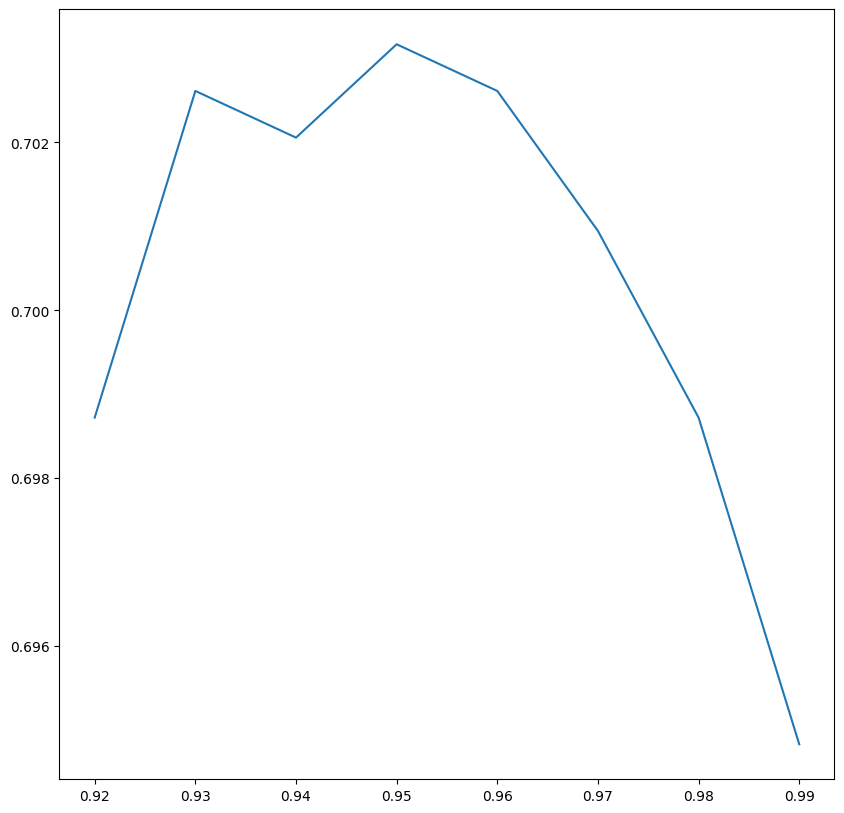

In [34]:
garantee_enforcement_rate_grid = np.arange(0.92, 1, 0.01)
min_rate_best_value_search(garantee_enforcement_rate_grid)

посмотрим поближе на область 0.94 - 0.97

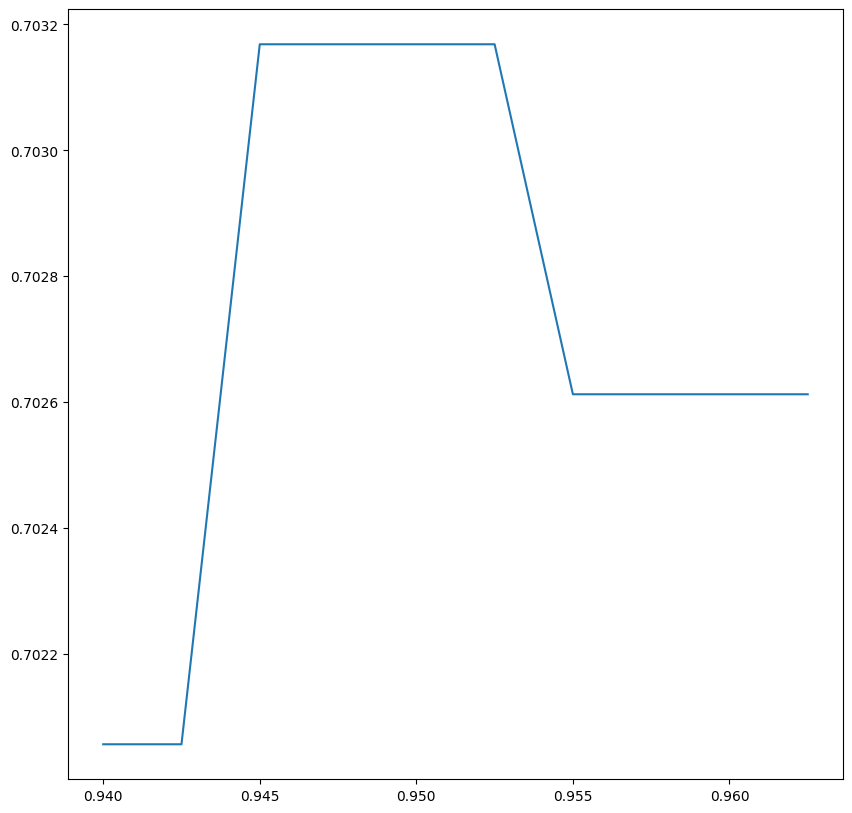

In [35]:
garantee_enforcement_rate_grid = np.arange(0.94, 0.9625, 0.0025)
min_rate_best_value_search(garantee_enforcement_rate_grid)

таким образом значение 0.95 - оптимально

### Предсказание test.json

### Сохранение результатов

### Выводы по исследованию